In [20]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Custom Dataset Class
class SpectrogramDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        spectrogram = np.load(self.file_paths[idx])
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)  # Add channel dim
        label = torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(0)  # Binary label
        
        if self.transform:
            spectrogram = self.transform(spectrogram)
        
        return spectrogram, label

# Define Data Paths
train_data_dir = 'data/train'

# Load File Paths and Labels
file_paths, labels = [], []
for label, sub_dir in enumerate(['drilling', 'jackhammer']):
    sub_path = os.path.join(train_data_dir, sub_dir)
    for file_name in os.listdir(sub_path):
        if file_name.endswith('.npy'):
            file_paths.append(os.path.join(sub_path, file_name))
            labels.append(label)

# Split into Train (90%) and Validation (10%)
train_files, val_files, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.1, random_state=None)

# Create Train and Validation Datasets
train_dataset = SpectrogramDataset(train_files, train_labels)
val_dataset = SpectrogramDataset(val_files, val_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load ResNet50 Model with Correct Weights Handling
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust for 1-channel input
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Early Stopping Setup
early_stopping_patience = 10
best_val_loss = float('inf')
early_stopping_counter = 0

# Training and Validation Loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_preds / total_preds

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_correct_preds = 0
    val_total_preds = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (outputs > 0.5).float()
            val_correct_preds += (preds == labels).sum().item()
            val_total_preds += labels.size(0)

    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_accuracy = val_correct_preds / val_total_preds

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}")
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Acc: {val_epoch_accuracy:.4f}")

    scheduler.step(val_epoch_loss)

    # Early Stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered. Training stopped.")
        break

Epoch 1/100 - Train Loss: 0.6118, Train Acc: 0.6728
Validation Loss: 47.3656, Validation Acc: 0.5111
Epoch 2/100 - Train Loss: 0.4010, Train Acc: 0.8198
Validation Loss: 0.2625, Validation Acc: 0.8667
Epoch 3/100 - Train Loss: 0.2271, Train Acc: 0.9086
Validation Loss: 0.3958, Validation Acc: 0.8000
Epoch 4/100 - Train Loss: 0.1632, Train Acc: 0.9432
Validation Loss: 1.9102, Validation Acc: 0.5333
Epoch 5/100 - Train Loss: 0.1850, Train Acc: 0.9358
Validation Loss: 0.2247, Validation Acc: 0.8778
Epoch 6/100 - Train Loss: 0.1491, Train Acc: 0.9420
Validation Loss: 0.4162, Validation Acc: 0.8444
Epoch 7/100 - Train Loss: 0.1334, Train Acc: 0.9457
Validation Loss: 0.0873, Validation Acc: 0.9556
Epoch 8/100 - Train Loss: 0.1104, Train Acc: 0.9580
Validation Loss: 0.2241, Validation Acc: 0.9222
Epoch 9/100 - Train Loss: 0.1488, Train Acc: 0.9457
Validation Loss: 2.9587, Validation Acc: 0.4889
Epoch 10/100 - Train Loss: 0.1180, Train Acc: 0.9654
Validation Loss: 0.3301, Validation Acc: 0.855

File: 103199-4-2-10.npy - Prob Score: 0.0000 - Predicted: 0
File: 118278-4-0-8.npy - Prob Score: 0.4419 - Predicted: 0
File: 118278-4-0-9.npy - Prob Score: 0.8791 - Predicted: 1
File: 130961-4-2-2.npy - Prob Score: 0.0001 - Predicted: 0
File: 130961-4-3-1.npy - Prob Score: 0.0001 - Predicted: 0
File: 130961-4-5-0.npy - Prob Score: 0.0000 - Predicted: 0
File: 130961-4-5-3.npy - Prob Score: 0.0000 - Predicted: 0
File: 14111-4-0-5.npy - Prob Score: 0.0031 - Predicted: 0
File: 147764-4-4-1.npy - Prob Score: 0.0000 - Predicted: 0
File: 151005-4-0-2.npy - Prob Score: 0.0000 - Predicted: 0
File: 151005-4-1-1.npy - Prob Score: 0.0000 - Predicted: 0
File: 165640-4-0-1.npy - Prob Score: 0.2106 - Predicted: 0
File: 165641-4-0-1.npy - Prob Score: 0.0082 - Predicted: 0
File: 166931-4-0-0.npy - Prob Score: 0.0005 - Predicted: 0
File: 166931-4-2-8.npy - Prob Score: 0.0002 - Predicted: 0
File: 167701-4-6-4.npy - Prob Score: 0.0000 - Predicted: 0
File: 167702-4-8-0.npy - Prob Score: 0.0000 - Predicted:

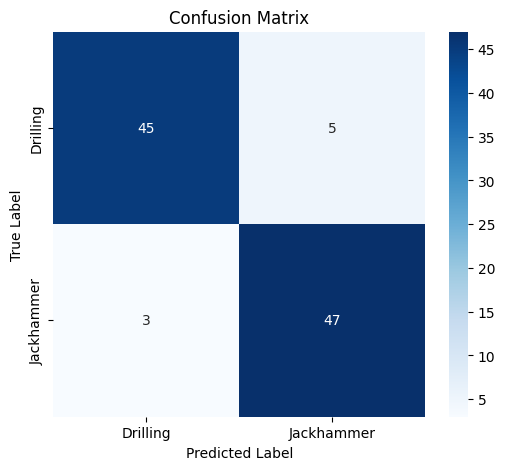

In [21]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define paths
test_data_dir = 'data/test'
best_model_path = 'best_model.pth'  # Path where the best model was saved

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)
model.to(device)

# Load best model weights
model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=True))
model.eval()  # Set to evaluation mode

# Load test dataset
test_file_paths, test_labels = [], []
for label, sub_dir in enumerate(['drilling', 'jackhammer']):
    sub_path = os.path.join(test_data_dir, sub_dir)
    for file_name in os.listdir(sub_path):
        if file_name.endswith('.npy'):
            test_file_paths.append(os.path.join(sub_path, file_name))
            test_labels.append(label)

test_dataset = SpectrogramDataset(test_file_paths, test_labels)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Run inference
all_preds, all_labels = [], []

with torch.no_grad():
    for file_path, (inputs, labels) in zip(test_file_paths, test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().item()
        predicted_label = 1 if outputs > 0.5 else 0

        all_preds.append(predicted_label)
        all_labels.append(labels.item())
        print(f"File: {os.path.basename(file_path)} - Prob Score: {outputs:.4f} - Predicted: {predicted_label}")

# Compute and display confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Drilling', 'Jackhammer'], yticklabels=['Drilling', 'Jackhammer'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()